In [1]:
from astropy import constants as const
from astropy import units as u
from random import *
from parameter_generator import *
from scipy.stats import stats
from scipy.stats import norm
import scipy.integrate as integrate
from astropy.table import Table
from iminuit import Minuit
import pysynphot as S
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0   

pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False


In [2]:
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from regions import CircleSkyRegion

result_table = Simbad.query_object("lmc")
galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg')
Circle = CircleSkyRegion(positions, 3.5/2 * u.deg)

# Cadence

In [3]:
dir_cadences = "D:\Projet de recherche\Stage\cadences"
all_my_cadence_files=["cadence_lmc_baseline2018a_extr_v1.csv",
                      "cadence_lmc_baseline_2snaps_v1_extr_v1.csv",
                      "cadence_lmc_baseline_v1_extr_v1.csv",
                      "cadence_lmc_rolling_nm_scale1_extr_v1.csv",
                      "cadence_lmc_rolling_scale0_extr_v1.csv"
                     ]


dir_atmo = "D:\Projet de recherche\Stage\Atmosphere"
all_my_atmo_files = ["lmc_baseline2018a_extr_v1_atmo.csv",
                     "lmc_baseline_2snaps_v1_extr_v1_atmo.csv",
                     "lmc_baseline_v1_extr_v1_atmo.csv",
                     "lmc_rolling_nm_scale1_extr_v1_atmo.csv",
                     "lmc_rolling_scale0_extr_v1_atmo.csv"
                    ]


dir_LSST = "D:\Projet de recherche\Stage"
LSST_file = "LSST_throughput.csv"

In [4]:
sel_cadence_idx = 0

In [5]:
cadence_file=os.path.join(dir_cadences,all_my_cadence_files[sel_cadence_idx])
df = pd.read_csv(cadence_file, index_col=0)
df

,observationId,night,observationStartMJD,fiveSigmaDepth,filter,airmass,skyBrightness,seeingFwhmEff,fieldId,fieldRA,fieldDec
0,10033,13,59865.307442,22.042763,y,1.326809,17.868655,0.734701,138,72.000005,-70.933132
1,10158,13,59865.364815,21.847938,y,1.362533,17.829956,0.859026,122,88.568878,-72.896915
2,10160,13,59865.365718,21.894638,y,1.315613,17.861954,0.841153,150,81.777206,-70.757749
3,10161,13,59865.366169,21.944466,y,1.267955,17.897698,0.822736,190,84.972540,-68.155026
4,10166,13,59865.368438,21.905326,y,1.277317,17.874108,0.842751,178,76.364237,-68.470535
...,...,...,...,...,...,...,...,...,...,...,...
752,2371968,3648,63500.338715,23.347211,r,1.338508,20.171447,1.313724,138,72.000005,-70.933132
753,2372034,3648,63500.370822,23.377553,r,1.391936,20.140500,1.252691,122,88.568878,-72.896915
754,2372039,3648,63500.373102,23.480260,r,1.278194,20.210373,1.190228,178,76.364237,-68.470535
755,2372040,3648,63500.373553,23.375525,r,1.328889,20.176793,1.284311,150,81.777206,-70.757749


In [6]:
df_good = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]

In [7]:
atmo_file = os.path.join(dir_atmo,all_my_atmo_files[sel_cadence_idx])
df_atmo = pd.read_csv(atmo_file, index_col=0)
df_atmo

,1,2,3,4,5,6,7,8,9,10,...,748,749,750,751,752,753,754,755,756,757
3000,0.006685,0.005863,0.006943,0.008378,0.008064,0.008187,0.006856,0.005650,0.006884,0.008172,...,0.001133,0.001360,0.000911,0.005435,0.005023,0.006416,0.005187,0.008035,0.006637,0.007782
3010,0.011053,0.009818,0.011440,0.013536,0.013081,0.013259,0.011310,0.009497,0.011351,0.013238,...,0.002240,0.002638,0.001839,0.009175,0.008555,0.010648,0.008802,0.013038,0.010981,0.012673
3020,0.016794,0.015079,0.017332,0.020177,0.019565,0.019804,0.017151,0.014633,0.017209,0.019776,...,0.003951,0.004579,0.003300,0.014185,0.013324,0.016233,0.013667,0.019508,0.016694,0.019016
3030,0.027757,0.025246,0.028544,0.032594,0.031731,0.032069,0.028279,0.024593,0.028364,0.032029,...,0.007809,0.008878,0.006663,0.023938,0.022677,0.026935,0.023179,0.031650,0.027611,0.030958
3040,0.033425,0.030548,0.034327,0.038920,0.037945,0.038327,0.034024,0.029800,0.034121,0.038282,...,0.010046,0.011342,0.008639,0.029049,0.027605,0.032483,0.028180,0.037854,0.033258,0.037072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11960,0.970875,0.970113,0.971113,0.972133,0.971932,0.972011,0.971033,0.969915,0.971059,0.972001,...,0.961002,0.961944,0.959724,0.969716,0.969333,0.970625,0.969485,0.971913,0.970830,0.971752
11970,0.970875,0.970113,0.971113,0.972133,0.971932,0.972011,0.971033,0.969915,0.971059,0.972001,...,0.961002,0.961944,0.959724,0.969716,0.969333,0.970625,0.969485,0.971913,0.970830,0.971752
11980,0.952743,0.951572,0.953109,0.954684,0.954373,0.954495,0.952986,0.951267,0.953026,0.954481,...,0.937810,0.939215,0.935917,0.950962,0.950374,0.952359,0.950608,0.954344,0.952674,0.954095
11990,0.952743,0.951572,0.953109,0.954684,0.954373,0.954495,0.952986,0.951267,0.953026,0.954481,...,0.937810,0.939215,0.935917,0.950962,0.950374,0.952359,0.950608,0.954344,0.952674,0.954095


In [8]:
df_LSST = pd.read_csv(os.path.join(dir_LSST, LSST_file), index_col=0)
df_LSST

,wl,u,g,r,i,z,y
0,300,0.000711,0.000000,0.000000,0.000034,0.000000,0.000000
1,301,0.000440,0.000000,0.000000,0.000155,0.000000,0.000000
2,302,0.000591,0.000000,0.000000,0.000072,0.000000,0.000000
3,303,0.000022,0.000000,0.000000,0.000034,0.000000,0.000000
4,304,0.000229,0.000000,0.000000,0.000034,0.000000,0.000000
...,...,...,...,...,...,...,...
896,1196,0.000029,0.000298,0.000088,0.000121,0.000560,0.016426
897,1197,0.000024,0.000357,0.000084,0.000150,0.000630,0.016413
898,1198,0.000016,0.000427,0.000080,0.000187,0.000711,0.016397
899,1199,0.000012,0.000501,0.000076,0.000235,0.000802,0.016303


# Spectrum

In [9]:
t = Table.read('table_summary_selectedcalspec.fits')

In [10]:
sel_spectrum_idx = 6

In [11]:
Spec = S.FileSpectrum(os.path.join(pysynphot_root_path, 'calspec', t["FILES"][sel_spectrum_idx]))
Spec.convert('photlam')

Warning, 29 of 6262 bins contained negative fluxes; they have been set to zero.


In [12]:
Spec.name

'D:\\PYSYN_CDBS\\grp\\redcat\\trds\\calspec\\hd106252_stis_005.fits'

In [13]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

In [14]:
rg = RealisticGenerator(xvts = 1000000)
param = rg.generate_parameters(mass = 10, nb_parameters = 10000)

369323 0.369323


Text(0.5, 0, '$u_0$')

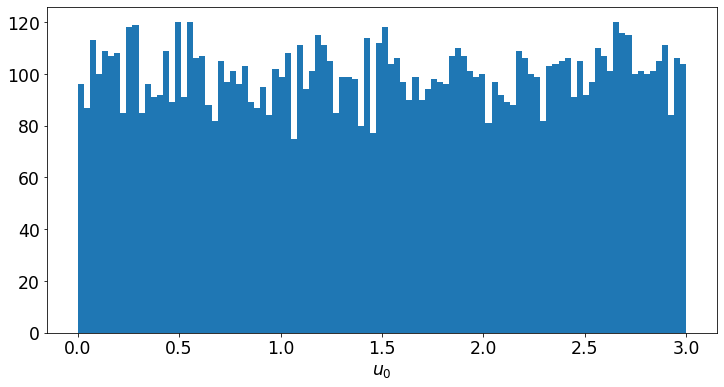

In [15]:
plt.hist(param["u0"], bins = 100);
plt.xlabel("$u_0$")

Text(0.5, 0, '$t_0$')

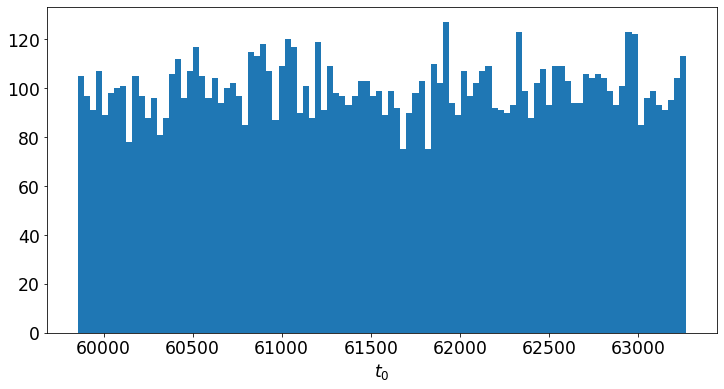

In [16]:
plt.hist(param["t0"], bins = 100);
plt.xlabel("$t_0$")

Text(0.5, 0, '$t_E$ distribution for M = 10 Solar Masses')

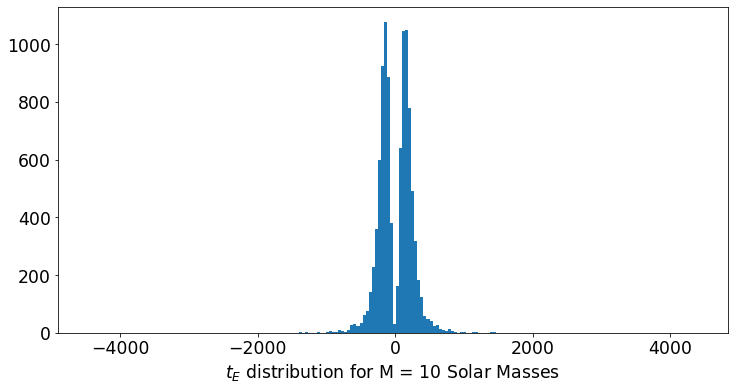

In [17]:
plt.hist(param["tE"], bins = 200);
plt.xlabel("$t_E$ distribution for M = 10 Solar Masses")

In [18]:
#Distribution t_0

NYEARS = 10
NDAYS = NYEARS*365.25
from scipy.stats import uniform
xmin = 0
xmax = NDAYS
N = 1000000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N)+ df["observationStartMJD"][0]

#plt.hist(list_t0,bins=int(NDAYS));
#plt.xlabel("$t_0$ (jours)")
#plt.title("Distribution des $t_0$")

In [19]:
#Distribution u0

N = 1000
uminmin = 0
uminmax = 3
umin = uniform.rvs(uminmin,uminmax,N)

#plt.hist(umin,bins=100)
#plt.xlabel("$u_{min}$")
#plt.ylabel("$p(u_{min})$")
#plt.title("Densité de probabilité de $u_{min}$")

In [20]:
#relative angular source-lens separation

def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

In [21]:
#Amplitude

def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

In [22]:
#Gaussian fit

def Gauss(x, A, mu ,sigma) :
    return A*np.exp(-(x-mu)**2/(2*sigma**2))/sigma/np.sqrt(2*np.pi)

In [23]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4)

In [24]:
#Linear fit

def linear(x, alpha, beta) : 
    return alpha*x + beta

In [25]:
D = Deff
Delta_T = EXPOSURE
F_ab = 3631*pow(10,-23)
Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)


In [26]:
F_b = []
N_pe = []
bp_atmo = []
all_obs = []
all_count = []
sigma_N = []
amp_err = []
all_bp = []

for i in range (len(df['observationStartMJD'])) :
    
    #if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) :
        
    bp = S.ArrayBandpass(df_LSST["wl"].values*10, df_atmo.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp)


for i in range (len(bp_atmo)) :

    if (df['filter'][i] == 'u') :
        
        bp = LSST_u * bp_atmo[i]
        all_bp.append(bp)
        
    elif (df['filter'][i] == 'g') :
        
        bp = LSST_g * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'r') :
        
        bp = LSST_r * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'i') :
        
        bp = LSST_i * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'z') :
        
        bp = LSST_z * bp_atmo[i]
        all_bp.append(bp)
    
    elif (df['filter'][i] == 'y') :
        
        bp = LSST_y * bp_atmo[i]
        all_bp.append(bp)

for bp in all_bp :
    
    obs = S.Observation(Spec, bp, force = 'extrap');
    all_obs.append(obs);
    
for obs in all_obs :
    
    all_count.append(obs.countrate()*EXPOSURE)

((y * Observation 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((u * Observation 66)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 67)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 68)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 69)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 70)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 71)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 72)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 73)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((i * Observation 130)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 131)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 132)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 133)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 134)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 135)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 136)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 137)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 194)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 195)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 196)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 197)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 198)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 199)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 200)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 201)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 258)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 259)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 260)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 261)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 262)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 263)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 264)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 265)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 322)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 323)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 324)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 325)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 326)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 327)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 328)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 329)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 386)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 387)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 388)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 389)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 390)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 391)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 392)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 393)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 450)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 451)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 452)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 453)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 454)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 455)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 456)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 457)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 514)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 515)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 516)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 517)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 518)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 519)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 520)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 521)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 578)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 579)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 580)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 581)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 582)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 583)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 584)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 585)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 642)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 643)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 644)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 645)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 646)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 647)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 648)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 649)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((z * Observation 706)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 707)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 708)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 709)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 710)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 711)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 712)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 713)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [27]:
for i in range (len(df["observationId"])) :
    
    F_b.append(F_ab * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))

In [28]:
for i in range (len(F_b)) :
    
    if (df['filter'].values[i] == 'u') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_u.throughput/Wavelength))
    
    if (df['filter'].values[i] == 'g') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_g.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'r') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_r.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'i') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_i.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'z') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_z.throughput/Wavelength))
            
    if (df['filter'].values[i] == 'y') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i]/(4*S.units.H)*integrate.trapz(LSST_y.throughput/Wavelength))


In [29]:
N = []

for i in range (len(bp_atmo)) :
    
    N.append(np.sqrt(N_pe[i] + all_count[i]))

In [30]:
%%time

n = 10
chi2 = [[] for i in range (n)]
chi2_linear = [[] for i in range (n)]
Delta_chi2 = [[] for i in range (n)]
Ndof = [[] for i in range (n)]
tE = 20
#list_u0 = []
efficiency = []
#no_points = 0

for k in range (n) :
    
    rejected = 0

    for i in range (len(param["t0"])) :
    
    
        
        t0 = list_t0[randrange(len(list_t0))]    
        u0 = param["u0"][randrange(len(param["u0"]))]   #random u0 for every event 
        #tE = param["tE"][randrange(len(param["tE"]))] 
        tmin = t0 - 5.*abs(tE)
        tmax = t0 + 5.*abs(tE)
    
    
    #Photometric Error
        x = []
        y_data = []
        amp_err = []

        for j in range (len(df['observationStartMJD'])) :
        
            if (df["observationStartMJD"][j] >= tmin) and (df["observationStartMJD"][j] <= tmax and ((df['fieldRA'][j] - galaxy_ra)**2 + (df['fieldDec'][j] - galaxy_dec)**2 < Circle.radius.value**2)) :
    
                amp_err.append(N[j] * A(u(df['observationStartMJD'].values[j]))/all_count[j])
                x.append(df["observationStartMJD"].values[j])
                y_data.append(A(u(df["observationStartMJD"].values[j])))
    
                            
        y = y_data + amp_err * np.random.randn(len(x))


        least_squares = LeastSquares(x, y, amp_err, Ab)
        m = Minuit(least_squares, u0 = u0 , t0 = t0, tE = tE)
    
        least_squares_linear = LeastSquares(x, y, amp_err, linear)
        m_linear = Minuit(least_squares_linear, alpha = 1 , beta = 1)

        m.migrad()
        m.hesse()
        m_linear.migrad()
        m_linear.hesse()
    

#Restrictive cuts 

    #if (len(x) <= 0) :
        
        #no_points += 1
    
        if (#len(x) > 1                                                # Ndof microlensing > 1                                           
        len(x) - m.nfit > 1                                                  # Ndof linear > 1
        and m.fval != 0                                                      # Chi2 microlensing != 0
        and m_linear.fval != 0                                           # Chi2 linear != 0
        and m.fval/(len(x) - m.nfit) < 2                                # Goodness of fit chi2/Ndof < 2
        and (m_linear.fval - m.fval)/(np.sqrt(2*(len(x) - m.nfit))) > 80 ) :  
        
            Ndof[k].append(len(x) - m.nfit)
        
            chi2[k].append(m.fval)
         
            chi2_linear[k].append(m_linear.fval)
        
            Delta_chi2[k].append((m_linear.fval - m.fval)/(np.sqrt((2*(len(x)- m.nfit)))))
        
        else :
        
            rejected += 1
    
    print(rejected)
    efficiency.append((len(param["t0"]) - rejected)/len(param["t0"]))
        
#print(rejected_events)
#print(no_points)

4025
4091
4053
4084
4034
3986
4104
4149
4008
4086
Wall time: 25min 1s


In [31]:
print(efficiency)

[0.5975, 0.5909, 0.5947, 0.5916, 0.5966, 0.6014, 0.5896, 0.5851, 0.5992, 0.5914]


In [32]:
Spec.name

'D:\\PYSYN_CDBS\\grp\\redcat\\trds\\calspec\\hd106252_stis_005.fits'

# Efficiency tE = 20 days,  $\Delta\chi^2$ > 20, 10000 events, ngc7293

0.5543, 0.5566, 0.5572, 0.5575, 0.555, 0.5527, 0.5556, 0.5556, 0.5546, 0.5586

# Efficiency tE = 20 days,  $\Delta\chi^2$ > 80, 10000 events, ngc7293

0.4807, 0.4784, 0.493, 0.499, 0.481, 0.4815, 0.4845, 0.4809, 0.4858, 0.5006

# Efficiency tE = 20 days,  $\Delta\chi^2$ > 80, 10000 events, g93-48
0.5291, 0.5363, 0.5313, 0.53, 0.5288, 0.5258, 0.5319, 0.5316, 0.5266, 0.5326

# Efficiency tE = 20 days,  $\Delta\chi^2$ > 80, 10000 events, hz4

0.4513, 0.4496, 0.4473, 0.445, 0.4479, 0.4518, 0.451, 0.4599, 0.4438, 0.4521

# Efficiency tE = 20 days,  $\Delta\chi^2$ > 80, 10000 events, alpha_lyr

0.601, 0.6001, 0.5954, 0.5946, 0.5886, 0.5983, 0.5974, 0.5923, 0.5955, 0.6016

# Efficiency tE = 20 days,  $\Delta\chi^2$ > 80, 10000 events, hd163466

0.597, 0.6074, 0.6008, 0.6077, 0.6004, 0.5945, 0.605, 0.5978, 0.5898, 0.5996

# Efficiency tE = 20 days,  $\Delta\chi^2$ > 80, 10000 events, hd101452

0.6003, 0.5957, 0.5944, 0.5933, 0.5836, 0.5987, 0.5956, 0.5998, 0.6044, 0.5949

# Efficiency tE = 20 days,  $\Delta\chi^2$ > 80, 10000 events, hd106252

0.5975, 0.5909, 0.5947, 0.5916, 0.5966, 0.6014, 0.5896, 0.5851, 0.5992, 0.5914

# Efficiency tE = 20 days,  $\Delta\chi^2$ > 80, 10000 events, flat

0.586, 0.5785, 0.586, 0.592, 0.5742, 0.5852, 0.5793, 0.5883, 0.5811, 0.5813

Text(0, 0.5, 'chi2')

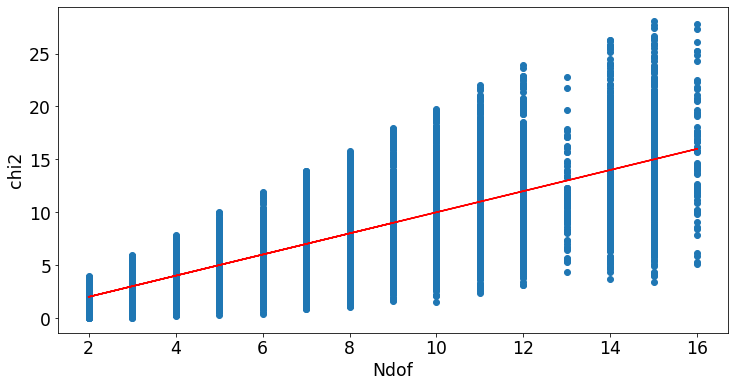

In [33]:
plt.plot(Ndof[0],Ndof[0], color = 'r')
plt.scatter(Ndof[0], chi2[0])
plt.xlabel("Ndof")
plt.ylabel("chi2")
#plt.xlim([0,20])
#plt.ylim([0,1])

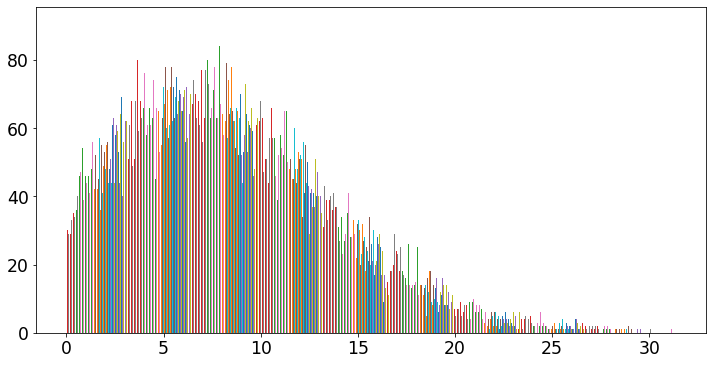

In [34]:
plt.hist(chi2, bins= 200);

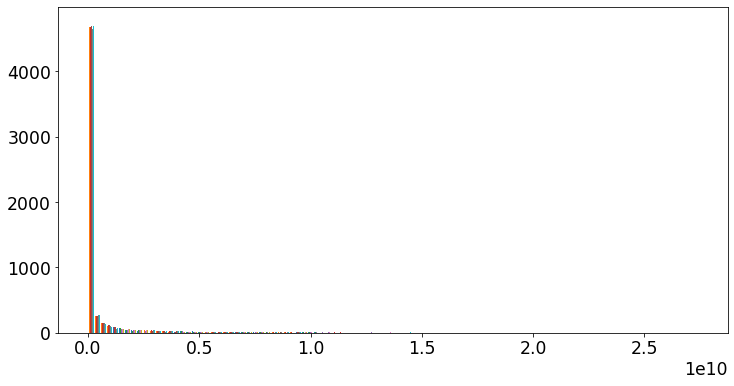

In [35]:
plt.hist(chi2_linear, bins = 100);

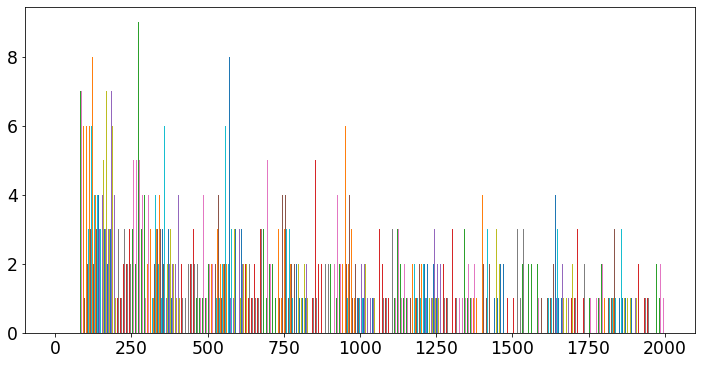

In [36]:
plt.hist(Delta_chi2, bins = 200, range = [0,2000]);
#plt.ylim(0,100)